# Benchmark: V1, V2, V3 vs. Scikit-learn

This notebook benchmarks my implemetations of LinearRegression vs. Scikit-learns `SGDRegressor`.

- `LinearRegression` (closed-form solution)
- `SGDRegressor` (iterative gradient-based optimizer)

The goal is to compare **training + prediction time** on the same synthetic dataset.


## Imports

In [14]:
import importlib
import sys
from pathlib import Path
import time
import platform
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Ensure repo root is on sys.path so we can import the C++ wrapper
repo_root = Path.cwd().resolve().parents[1]
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

import coreflux_rust
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from wrapper import coreflux_cpp

Helpers for benchmarks

In [24]:
def make_dataset(
    n_train: int,
    n_test: int,
    n_features: int,
    rng: np.random.Generator,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate a synthetic regression dataset + column-wise normalization.
    """
    X_train = rng.normal(size=(n_train, n_features))
    w_true = rng.normal(size=n_features)
    y_train = X_train @ w_true + rng.normal(scale=0.1, size=n_train)

    X_test = rng.normal(size=(n_test, n_features))

    norms = np.linalg.norm(X_train, axis=0)
    norms[norms == 0.0] = 1.0

    X_train_scaled = X_train / norms
    X_test_scaled = X_test / norms

    return X_train_scaled, y_train, X_test_scaled


def time_model(label: str, fn, repeat: int = 3) -> float:
    """
    Run `fn()` multiple times and return the mean runtime in seconds.
    Also prints the mean for logging.
    """
    times = []
    for _ in range(repeat):
        start = time.perf_counter()
        fn()
        times.append(time.perf_counter() - start)
    mean_t = float(np.mean(times))
    print(f"{label}: mean={mean_t:.4f}s over {repeat} runs")
    return mean_t


def benchmark_models_on_dataset(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    models: dict[str, callable],
    repeat: int = 3,
) -> dict[str, float]:
    """
    Given a fixed dataset, benchmark multiple model factories.
    
    models: dict mapping label -> factory function that returns a *fresh* model.
            e.g. {
              "sgd": lambda: SGDRegressor(...),
              "cpp_v21": lambda: LinearRegressionV21(...),
            }
    Returns: dict[label -> mean_runtime_seconds]
    """
    results: dict[str, float] = {}

    for label, factory in models.items():
        def run():
            model = factory()
            model.fit(X_train, y_train)
            _ = model.predict(X_test)

        mean_t = time_model(label, run, repeat=repeat)
        results[label] = mean_t

    return results

def time_model(label: str, fn, repeat: int = 3) -> float:
    """
    Run `fn()` multiple times and return the mean runtime in seconds.
    Also prints the mean for logging.
    """
    times = []
    for _ in range(repeat):
        start = time.perf_counter()
        fn()
        times.append(time.perf_counter() - start)
    mean_t = float(np.mean(times))
    print(f"{label}: mean={mean_t:.4f}s over {repeat} runs")
    return mean_t


def benchmark_models_on_dataset(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    models: dict[str, callable],
    repeat: int = 3,
) -> dict[str, float]:
    """
    Given a fixed dataset, benchmark multiple model factories.
    
    models: dict mapping label -> factory function that returns a *fresh* model.
            e.g. {
              "sgd": lambda: SGDRegressor(...),
              "cpp_v21": lambda: LinearRegressionV21(...),
            }
    Returns: dict[label -> mean_runtime_seconds]
    """
    results: dict[str, float] = {}

    for label, factory in models.items():
        def run():
            model = factory()
            model.fit(X_train, y_train)
            _ = model.predict(X_test)

        mean_t = time_model(label, run, repeat=repeat)
        results[label] = mean_t

    return results

def sgd_factory():
    return SGDRegressor(
        learning_rate="constant",
        eta0=0.05,
        max_iter=1_000,
        penalty=None,
        random_state=0,
    )


def cpp_v21_factory():
    return coreflux_cpp.LinearRegressionV21(
        iterations=1_000,
        learning_rate=0.05,
    )


def cpp_v22_factory():
    return coreflux_cpp.LinearRegressionV22(
        iterations=1_000,
        learning_rate=0.05,
    )



KeyboardInterrupt: 

## scikit-learn: `SGDRegressor`

In [8]:
rng = np.random.default_rng(0)

train_sizes = [200_000]
n_features = 40

sgd_times = []

for n_train in train_sizes:
    n_test = n_train // 10
    print(f"\n=== n_train={n_train}, n_test={n_test}, n_features={n_features} ===")
    X_train_scaled, y_train, X_test_scaled = make_dataset(
        n_train, n_test, n_features, rng
    )

    results = benchmark_models_on_dataset(
        X_train_scaled,
        y_train,
        X_test_scaled,
        models={
            "sklearn SGDRegressor (1k iters)": sgd_factory,
        },
        repeat=3,
    )

    sgd_times.append(results["sklearn SGDRegressor (1k iters)"])


=== n_train=200000, n_test=20000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=2.1522s over 3 runs


## Rust: `LinearRegression`

In [16]:
rust_model = coreflux_rust.LinearRegression(
    learning_rate=0.05,
    iterations=1000,
    mode=coreflux_rust.Mode.Regression,
)
rust_model.fit(X_train_scaled, y_train)
_ = rust_model.predict(X_test_scaled)

rng = np.random.default_rng(0)

train_sizes = [200_000]
n_features = 40

r_times = []

for n_train in train_sizes:
    n_test = n_train // 10
    print(f"\n=== n_train={n_train}, n_test={n_test}, n_features={n_features} ===")
    X_train_scaled, y_train, X_test_scaled = make_dataset(
        n_train, n_test, n_features, rng
    )

    results = benchmark_models_on_dataset(
        X_train_scaled,
        y_train,
        X_test_scaled,
        models={
            "Rust V1 (1k iters)": rust_model,
        },
        repeat=3,
    )

    r_times.append(results["Rust V1 (1k iters)"])


AttributeError: module 'coreflux_rust' has no attribute 'LinearRegression'

## C++ V21: `LinearRegression`


In [17]:
rng = np.random.default_rng(0)

train_sizes = [200_000]
n_features = 40

v21_times = []

for n_train in train_sizes:
    n_test = n_train // 10
    print(f"\n=== n_train={n_train}, n_test={n_test}, n_features={n_features} ===")
    X_train_scaled, y_train, X_test_scaled = make_dataset(
        n_train, n_test, n_features, rng
    )

    results = benchmark_models_on_dataset(
        X_train_scaled,
        y_train,
        X_test_scaled,
        models={
            "CoreFlux C++ V21 (1k iters)": cpp_v21_factory,
        },
        repeat=3,
    )

    v21_times.append(results["CoreFlux C++ V21 (1k iters)"])


=== n_train=200000, n_test=20000, n_features=40 ===
CoreFlux C++ V21 (1k iters): mean=1.3373s over 3 runs


## Initial Results

*   **sklearn SGDRegressor (1k iters):** min=2.0389s  mean=2.0528s over 5 runs
*   **Rust LinearRegression (1k iters):** min=16.9185s  mean=17.1103s over 5 runs
*   **C++ V21 LinearRegression (1000 iters):** min=1.0500s  mean=1.1093s over 5 runs

### Interpretation

Our optimized C++ batch gradient descent is the fastest implementation. It outperforms both:
*   the naive, single-threaded Rust version 
*   and scikit-learn’s SGDRegressor, which runs only on one CPU thread

`SGDRegressor` remains competitive because it performs stochastic updates (less work per iteration) and uses highly optimized vectorized operations. However, because it lacks multi-threading, it eventually falls behind on larger datasets.

The C++ implementation benefits from:

*   OpenMP parallelism
*   tight memory layout and cache-friendly access patterns
(contiguous rows, predictable iteration order, reduced cache misses)

As dataset size increases, these advantages scale well, and we expect the performance gap to widen.
We stop benchmarking the Rust version here due to its significantly slower performance.

## Scaling Benchmark: Dataset Size vs Runtime
We now benchmark how sklearn's SGDRegressor and the C++ CoreFlux LinearRegression
scale as we increase the training set size.
For each training size n_train, we:
  - generate a fresh synthetic dataset
  - apply the same column-wise normalization
  - measure train + predict time for:
      * sklearn SGDRegressor (1k iterations)
      * C++ LinearRegression (1k iterations)
  - repeat a few times and take the mean
Finally, we plot runtime vs n_train.

Some helper functions for creating dataset and timing the model

In [19]:
rng = np.random.default_rng(0)

train_sizes = [50_000, 100_000, 200_000, 400_000, 800_000, 1_600_000]
n_features = 40

sgd_times = []
v21_times = []

for n_train in train_sizes:
    n_test = n_train // 10
    print(f"\n=== n_train={n_train}, n_test={n_test}, n_features={n_features} ===")
    X_train_scaled, y_train, X_test_scaled = make_dataset(
        n_train, n_test, n_features, rng
    )

    results = benchmark_models_on_dataset(
        X_train_scaled,
        y_train,
        X_test_scaled,
        models={
            "sklearn SGDRegressor (1k iters)": sgd_factory,
            "CoreFlux C++ V21 (1k iters)": cpp_v21_factory,
        },
        repeat=3,
    )

    sgd_times.append(results["sklearn SGDRegressor (1k iters)"])
    v21_times.append(results["CoreFlux C++ V21 (1k iters)"])



=== n_train=50000, n_test=5000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=0.2508s over 3 runs
CoreFlux C++ V21 (1k iters): mean=0.1857s over 3 runs

=== n_train=100000, n_test=10000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=0.7721s over 3 runs
CoreFlux C++ V21 (1k iters): mean=0.3069s over 3 runs

=== n_train=200000, n_test=20000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=2.2170s over 3 runs
CoreFlux C++ V21 (1k iters): mean=1.2778s over 3 runs

=== n_train=400000, n_test=40000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=4.9919s over 3 runs
CoreFlux C++ V21 (1k iters): mean=4.7039s over 3 runs

=== n_train=800000, n_test=80000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=10.0145s over 3 runs
CoreFlux C++ V21 (1k iters): mean=10.0310s over 3 runs

=== n_train=1600000, n_test=160000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=21.0748s over 3 runs
CoreFlux C++ V21 (1k iters): mean=19.8105s over 3 runs


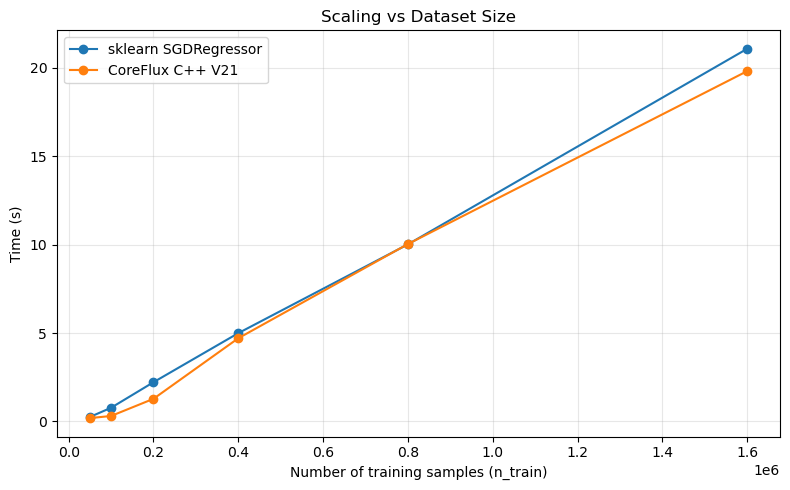

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, sgd_times, marker="o", label="sklearn SGDRegressor")
plt.plot(train_sizes, v21_times, marker="o", label="CoreFlux C++ V21")

plt.xlabel("Number of training samples (n_train)")
plt.ylabel("Time (s)")
plt.title("Scaling vs Dataset Size")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig("../../plots/linear_scaling_v21_vs_sgdr_medium_dataset.png", dpi=200, bbox_inches="tight")
plt.show()

This is actually not what I expected at all. Before running the benchmarks I assumed the performance gap would just keep growing, but nope we’re around 2× faster at n=200k, and after that the times basically start hugging each other.

My current guess: we’re just slamming into memory bandwidth. At some point (feels like ~300k samples?), the CPU can’t push data through the memory bus any faster, so both my C++ code and scikit just end up being limited by how fast they can read the data. Once you hit that wall, everything starts scaling pretty much linearly, so the relative speedup shrinks.

To check if that’s actually what’s happening, I’ll run the next benchmark on even bigger datasets. If the curves stay parallel, memory is a plausible explanation.

In [22]:
rng = np.random.default_rng(0)

train_sizes = [50_000, 100_000, 200_000, 400_000, 800_000, 1_600_000, 3_200_000, 6_400_000]
n_features = 40

sgd_times = []
v21_times = []

for n_train in train_sizes:
    n_test = n_train // 10
    print(f"\n=== n_train={n_train}, n_test={n_test}, n_features={n_features} ===")
    X_train_scaled, y_train, X_test_scaled = make_dataset(
        n_train, n_test, n_features, rng
    )

    results = benchmark_models_on_dataset(
        X_train_scaled,
        y_train,
        X_test_scaled,
        models={
            "sklearn SGDRegressor (1k iters)": sgd_factory,
            "CoreFlux C++ V21 (1k iters)": cpp_v21_factory,
        },
        repeat=3,
    )

    sgd_times.append(results["sklearn SGDRegressor (1k iters)"])
    v21_times.append(results["CoreFlux C++ V21 (1k iters)"])


=== n_train=50000, n_test=5000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=0.2490s over 3 runs
CoreFlux C++ V21 (1k iters): mean=0.1725s over 3 runs

=== n_train=100000, n_test=10000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=0.7956s over 3 runs
CoreFlux C++ V21 (1k iters): mean=0.3315s over 3 runs

=== n_train=200000, n_test=20000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=2.2539s over 3 runs
CoreFlux C++ V21 (1k iters): mean=1.4471s over 3 runs

=== n_train=400000, n_test=40000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=5.0447s over 3 runs
CoreFlux C++ V21 (1k iters): mean=4.8497s over 3 runs

=== n_train=800000, n_test=80000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=10.0963s over 3 runs
CoreFlux C++ V21 (1k iters): mean=10.2335s over 3 runs

=== n_train=1600000, n_test=160000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=21.1227s over 3 runs
CoreFlux C++ V21 (1k iters): mean=20.0797s over 3 runs

=== n

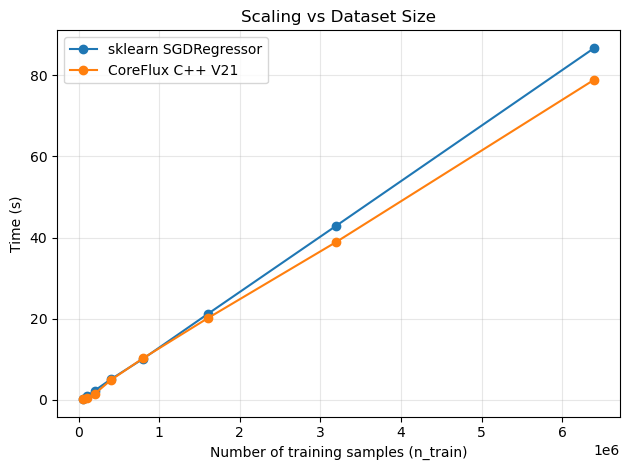

In [23]:
plt.plot(train_sizes, sgd_times, marker="o", label="sklearn SGDRegressor")
plt.plot(train_sizes, v21_times, marker="o", label="CoreFlux C++ V21")

plt.xlabel("Number of training samples (n_train)")
plt.ylabel("Time (s)")
plt.title("Scaling vs Dataset Size")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig("../../plots/linear_scaling_v21_vs_sdgr_large_dataset.png", dpi=200, bbox_inches="tight")
plt.show()

The new plot kind of confirmed it. Once we crank the dataset up into the millions, the curves really do start running almost perfectly parallel; which strongly hints that we’re sitting right on the memory wall. What’s interesting, though, is that at the extreme sizes (like 3.2M and 6.4M samples) my C++ version actually starts to pull away again. Not massively, but enough to be noticeable.

My best guess is that when you push things this hard, all the little bits of overhead inside sklearn (Python layers, single-threaded updates, allocator noise, etc.) finally start to matter. Meanwhile my C++ implementation is basically just a tight loop with OpenMP, so even though both of us are fighting over the same RAM bandwidth, my version wastes less time on everything around it.

## Scaling by Number of Features
In the previous section, we scaled the dataset by the number of samples.
Now we repeat a similar experiment but keep `n_samples` fixed and increase 
the number of features. This helps us understand how the implementations
behave when computation per sample grows (rather than memory traffic alone).

Run the tests

In [25]:
rng = np.random.default_rng(0)

feature_sizes = [10, 20, 40, 80, 160, 320]
n_samples = 200_000
n_test = n_samples // 10

sgd_feat_times = []
v21_feat_times = []
v22_feat_times = []

for n_features in feature_sizes:
    print(f"\n=== n_samples={n_samples}, n_test={n_test}, n_features={n_features} ===")

    X_train_scaled, y_train, X_test_scaled = make_dataset(
        n_samples, n_test, n_features, rng
    )

    results = benchmark_models_on_dataset(
        X_train_scaled,
        y_train,
        X_test_scaled,
        models={
            "sklearn SGDRegressor (1k iters)": sgd_factory,
            "CoreFlux C++ V21 (1k iters)": cpp_v21_factory,
        },
        repeat=3,
    )

    sgd_feat_times.append(results["sklearn SGDRegressor (1k iters)"])
    v21_feat_times.append(results["CoreFlux C++ V21 (1k iters)"])



=== n_samples=200000, n_test=20000, n_features=10 ===
sklearn SGDRegressor (1k iters): mean=0.4689s over 3 runs
CoreFlux C++ V21 (1k iters): mean=0.2633s over 3 runs

=== n_samples=200000, n_test=20000, n_features=20 ===
sklearn SGDRegressor (1k iters): mean=1.0705s over 3 runs
CoreFlux C++ V21 (1k iters): mean=0.3598s over 3 runs

=== n_samples=200000, n_test=20000, n_features=40 ===
sklearn SGDRegressor (1k iters): mean=2.2875s over 3 runs
CoreFlux C++ V21 (1k iters): mean=1.2767s over 3 runs

=== n_samples=200000, n_test=20000, n_features=80 ===
sklearn SGDRegressor (1k iters): mean=3.2573s over 3 runs
CoreFlux C++ V21 (1k iters): mean=4.3460s over 3 runs

=== n_samples=200000, n_test=20000, n_features=160 ===
sklearn SGDRegressor (1k iters): mean=5.3471s over 3 runs
CoreFlux C++ V21 (1k iters): mean=9.2304s over 3 runs

=== n_samples=200000, n_test=20000, n_features=320 ===
sklearn SGDRegressor (1k iters): mean=9.3955s over 3 runs
CoreFlux C++ V21 (1k iters): mean=17.8349s over 3 

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(feature_sizes, sgd_feat_times, marker="o", label="SGD")
plt.plot(feature_sizes, v21_feat_times, marker="o", label="C++ V21")
plt.xlabel("n_features")
plt.ylabel("Time (s)")
plt.title("Scaling with number of features")
plt.grid(True)
plt.legend()
plt.tight_layout()

Okay, what’s next? Before jumping into CUDA programming, there’s clearly more performance to squeeze out on the CPU side—especially now that I know where this version actually wins and where it falls apart. The benchmarks showed a pretty clear pattern:
*   For many samples and moderate feature sizes, my C++ v21 beats SGDRegressor easily.
*   But as soon as the number of features starts getting large, sklearn takes over and the gap grows fast.

This tells me that v21 is great at streaming through lots of rows (nice cache behavior + parallel loops) but not great at handling very wide feature vectors. And honestly, that makes sense, the inner loops are basically scalar C++ code with no explicit SIMD, so sklearn’s heavily vectorized math is naturally going to dominate in the “hundreds of features” regime.

Knowing that, there are some very obvious places to improve v21 before touching GPUs. And since we’ve confirmed we’re hitting the memory wall in some cases, there’s definitely still headroom on the CPU side just by being smarter with data movement and math efficiency.

Some ideas worth testing:
*   **float32 instead of float64:**
    *   float64 is total overkill for almost every ML dataset. Switching to float32 instantly halves memory traffic and doubles effective bandwidth. If someone really needs 64-bit precision, we can expose a toggle later.
*   **fusing the passes:** 
    *   right now prediction, error, and gradient computation touch X in separate loops. If we fuse them into one big loop, we only stream the dataset once per iteration instead of 2–3 times.
*   **faster reductions:** 
    *   the local-buffer + #pragma omp critical pattern works, but it’s not ideal. Switching to OpenMP’s built-in reduction or a chunked, tree-style reduction would remove the critical section overhead entirely.
*   **SIMD / vectorization:**
    *    the inner dot-product loop is a perfect target for AVX2/AVX-512. Even just helping the compiler auto-vectorize (via restrict, pointer hints, or reorganized loops) could give a huge speedup for large feature sizes.
*   **thread/core tuning:** 
    *   messing with OMP_NUM_THREADS, thread pinning, and schedule(static) vs dynamic might improve stability on big datasets.

Instead of modifying the current implementation, I’ll build a brand-new version (v22) next to it. That way I can benchmark the two versions head-to-head and see exactly how much each optimization moves the needle.


## 

## C++ V22 testing

In [2]:
def bench_features_for_n(n_samples: int, n_test: int, feature_sizes: list[int]):
    sgd_times = []
    cpp_times = []

    print(f"\n### n_samples = {n_samples}, n_test = n = {n_test}")
    for n_features in feature_sizes:
        print(f"\n--- n_features = {n_features} ---")
        X_train_scaled, y_train, X_test_scaled = make_dataset(n_samples, n_test, n_features, rng)

        # sklearn SGDRegressor
        def run_sgd():
            model = SGDRegressor(
                learning_rate="constant",
                eta0=0.05,
                max_iter=1_000,
                penalty=None,
                random_state=0,
            )
            model.fit(X_train_scaled, y_train)
            _ = model.predict(X_test_scaled)

        sgd_t = time_model("sklearn SGDRegressor (1k iters)", run_sgd)
        sgd_times.append(sgd_t)

        # C++ CoreFlux LinearRegressionV21
        def run_cpp():
            model = coreflux_cpp.LinearRegressionV22(
                iterations=1_000,
                learning_rate=0.05,
            )
            model.fit(X_train_scaled, y_train)
            _ = model.predict(X_test_scaled)

        cpp_t = time_model("C++ LinearRegressionV22 (1k iters)", run_cpp)
        cpp_times.append(cpp_t)

    return np.array(feature_sizes), np.array(sgd_times), np.array(cpp_times)

In [5]:
feature_sizes = [10, 20, 40, 80]
sample_size = [200_000, 800_000, 1_600_000]
test_sample_size = [20_000, 40_000, 80_000]

results = {}
for n_samples, n_test_samples in zip(sample_size, test_sample_size):
    sizes, sgd_times, cpp_times = bench_features_for_n(n_samples, n_test_samples, feature_sizes)
    results[n_samples] = (sizes, sgd_times, cpp_times)


### n_samples = 200000, n_test = n = 20000

--- n_features = 10 ---
sklearn SGDRegressor (1k iters): mean=0.4828s over 3 runs
C++ LinearRegressionV22 (1k iters): mean=0.2548s over 3 runs

--- n_features = 20 ---
sklearn SGDRegressor (1k iters): mean=1.2054s over 3 runs
C++ LinearRegressionV22 (1k iters): mean=0.3035s over 3 runs

--- n_features = 40 ---
sklearn SGDRegressor (1k iters): mean=2.3191s over 3 runs
C++ LinearRegressionV22 (1k iters): mean=0.4393s over 3 runs

--- n_features = 80 ---
sklearn SGDRegressor (1k iters): mean=3.2552s over 3 runs
C++ LinearRegressionV22 (1k iters): mean=1.2662s over 3 runs

### n_samples = 800000, n_test = n = 40000

--- n_features = 10 ---
sklearn SGDRegressor (1k iters): mean=4.4740s over 3 runs
C++ LinearRegressionV22 (1k iters): mean=0.8240s over 3 runs

--- n_features = 20 ---
sklearn SGDRegressor (1k iters): mean=8.0155s over 3 runs
C++ LinearRegressionV22 (1k iters): mean=1.9754s over 3 runs

--- n_features = 40 ---
sklearn SGDRegressor (1